In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:30:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(40)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33083 instead
  http_address["port"], self.http_server.port


In [7]:
client

Client Scheduler: tcp://10.12.206.51:45260 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/33083/status,Cluster Workers: 32 Cores: 32 Memory: 800.00 GB


### A couple useful functions

In [8]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [9]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

### get the list of available members/files
- there were some model crashes
- therefore these are not necessarily sequential

In [10]:
#fetch some useful information about the parameters
csvfile='/glade/scratch/djk2120/PPEn08/OAAT_apr2020.csv'
keys=pd.read_csv(csvfile,header=None)
#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2
#find all the files
histdir='/glade/scratch/djk2120/PPEn08/CTL2010/hist/'
tape='h0'
members=[]
files=[]
skips=['kc25_coef','ko25_coef','cp25_yr2000']
for member,param in zip(keys[0],keys[1]):
    file=glob.glob(histdir+'*'+member+'*'+tape+'*.nc')
    if len(file)>0:
        skipme=False
        for skip in skips:
            if skip in param:
                skipme=True
        if not skipme:
            members.append(member)
            files.append(file[0])
#extract parameter info
params=[]
minmax=[]
for member in members:
    ix = member==keys[0]
    params.append(keys[1][ix].values[0])
    minmax.append(keys[2][ix].values[0])
uniques = list(set(params))   

# work with 1 file
### notes 
- this is sparsegrid output, only 400 gridcells
- sparsegrid_landarea.nc can be used to recompose global mean
- xarray thinks cesm output starts in february

In [11]:
ds = xr.open_dataset(files[0])
ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

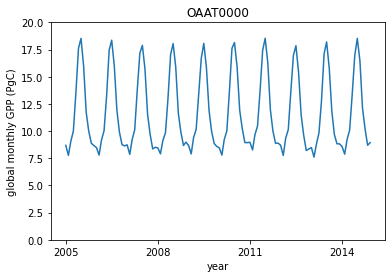

In [12]:
## make a global timeseries
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2
cf  = 1e-9*24*60*60*month_wts(10)   #gC/m2/s -> PgC/month
gpp = cf*(la*ds.GPP).sum(dim='gridcell')
gpp.plot()
plt.ylim([0,20])
plt.xlabel('year')
plt.ylabel('global monthly GPP (PgC)')
plt.title(members[0]);

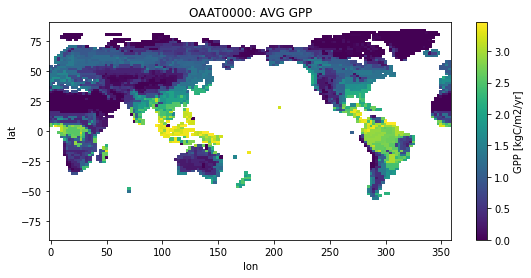

In [13]:
#calc avg gpp
gpp = 24*60*60/1000*(month_wts(10)*ds.GPP).groupby('time.year').sum().mean(dim='year')
#set up some stuff for plotting
gpp.name='GPP'
gpp.attrs={'units':'kgC/m2/yr'}
#regrid to lat/lon
gpp_map = get_map(gpp)

#plot
plt.figure(figsize=[9,4])
gpp_map.plot()
plt.title(members[0]+': AVG GPP');

# Work with multiple ensemble members

In [14]:
def get_ds(fields):
    def preprocess(ds):
        return ds[fields]
    ds=xr.open_mfdataset(files,
                 combine='nested',
                 concat_dim='ens',
                 parallel=True,
                 preprocess=preprocess)
    nyrs=10
    ds['time'] = xr.cftime_range(str(2005),periods=12*nyrs,freq='MS') #fix time bug
    ds['param'] = xr.DataArray(params,dims='ens')
    return ds

In [16]:
fields = ['SOILWATER_10CM','EFLX_LH_TOT']
ds = get_ds(fields)
ds

<xarray.Dataset>
Dimensions:         (ens: 365, gridcell: 400, time: 120)
Coordinates:
  * time            (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    SOILWATER_10CM  (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    EFLX_LH_TOT     (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    param           (ens) <U32 'default' 'taulnir' 'taulnir' ... 'CWD' 'CWD'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/26/21 15:05:00
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n08_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn08_CTL2010_PROD_001
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                CTL2010_OAAT0000_postSASUresta...
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn08_CTL2010_PROD_001.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [46]:
def param_effect(da,p,op,cf):
    
    #calculate either mean or IAV
    nyrs=10
    if op=='mean':
        x = cf*(la*(month_wts(nyrs)/nyrs*da).sum(dim='time')).sum(dim='gridcell').compute()
    elif op=='IAV':
        x = cf*(month_wts(nyrs)*(la*da).sum(dim='gridcell')).groupby('time.year').sum().std(dim='year').compute()

    #subtract param-lo from param-hi to get the perturbation effect    
    effect=[]
    for param in uniques:
        ix = p==param
        x2 = x.isel(ens=ix)
        if len(x2)==2:
            #has min and max
            effect.append(abs(x2[0]-x2[1]).values)
        else:
            #only has one or the other, sub in default x[0]
            effect.append(abs(x[0]-x2[0]).values)
    effect=np.array(effect)
    return effect,x

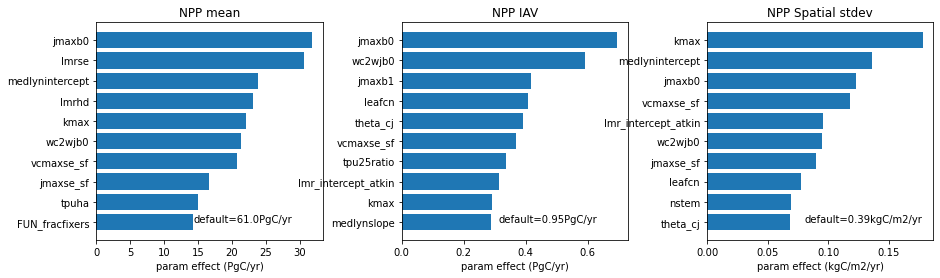

In [15]:
cf1=24*60*60*1e-9
cf2=24*60*60*1e-3
cfs=[cf1,cf1,cf2]
ops=['mean','IAV','Spatial stdev']
units=['PgC/yr','PgC/yr','kgC/m2/yr']
field='NPP'
da=get_da(field)
plt.figure(figsize=[15,4])
i=0

ranks=[]

for op,cf,unit in zip(ops,cfs,units):
    i+=1 
    effect,x=param_effect(da,op,cf)
    a = np.sort(effect)
    b = np.argsort(effect)
    top10 = [uniques[i] for i in b[-10:]]

    plt.subplot(1,3,i)
    plt.barh(range(10),a[-10:])
    plt.yticks(range(10),top10);
    plt.xlabel('param effect ('+unit+')')
    plt.title(field+' '+op);
    
    xmid = 0.45*max(a)
    xdef = '%s' % float('%.2g' % x[0].values)
    plt.text(xmid,0,'default='+xdef+unit)
    
plt.subplots_adjust(wspace=0.35)

In [64]:
for field in fields:
    print(field)

GPP
COL_FIRE_CLOSS
HR
AR
TOTVEGC
TOTSOMC_1m
QVEGT
QRUNOFF
TWS
SOILWATER_10CM
TV
TSOI_10CM
TLAI
FSRVD
FSRVI


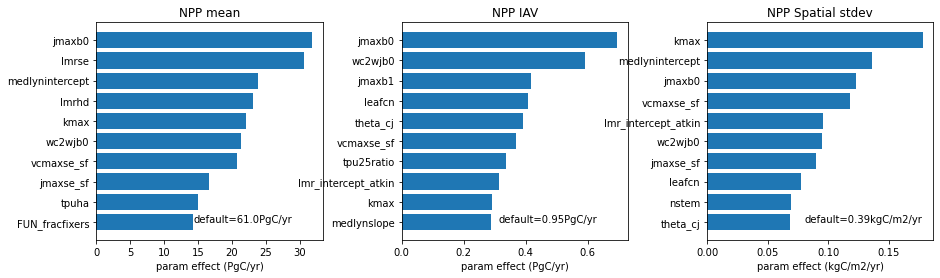

In [15]:
cf1=24*60*60*1e-9
cf2=24*60*60*1e-3
cfs=[cf1,cf1,cf2]
ops=['mean','IAV','Spatial stdev']
units=['PgC/yr','PgC/yr','kgC/m2/yr']
field='NPP'
da=get_da(field)
plt.figure(figsize=[15,4])
i=0

ranks=[]

for op,cf,unit in zip(ops,cfs,units):
    i+=1 
    effect,x=param_effect(da,op,cf)
    a = np.sort(effect)
    b = np.argsort(effect)
    top10 = [uniques[i] for i in b[-10:]]
    rank = numpy.empty_like(a)
    rank[b] = numpy.arange(len(a))
    ranks.append(rank)
    plt.subplot(1,3,i)
    plt.barh(range(10),a[-10:])
    plt.yticks(range(10),top10);
    plt.xlabel('param effect ('+unit+')')
    plt.title(field+' '+op);
    
    xmid = 0.45*max(a)
    xdef = '%s' % float('%.2g' % x[0].values)
    plt.text(xmid,0,'default='+xdef+unit)
    
plt.subplots_adjust(wspace=0.35)

In [35]:
fields={}

cfluxes = ['GPP','COL_FIRE_CLOSS','HR','AR']
cf1 = 24*60*60*1e-9; cf2 = 24*60*60*1e-3
units = ['PgC/yr','PgC/yr','kgC/m2/yr']
for field in cfluxes:
    fields[field]={'cfs':[cf1,cf1,cf2],'units':units}

cpools = ['TOTVEGC','TOTSOMC_1m']
cf1 = 1e-9/365; cf2 = 1e-3/365
units = ['PgC','PgC','kgC/m2']
for field in cpools:
    fields[field]={'cfs':[cf1,cf1,cf2],'units':units}
    
hfluxes = ['QVEGT','QRUNOFF']
cf1 = 24*60*60*1e-9; cf2 = 24*60*60*1e-1
units = ['TtH2O/yr','TtH2O/yr','cm/yr']
for field in hfluxes:
    fields[field]={'cfs':[cf1,cf1,cf2],'units':units}
    
hpools = ['TWS','SOILWATER_10CM']
cf1 = 1e-9/365; cf2 = 1/365
units = ['TtH2O','TtH2O','mm']
for field in hpools:
    fields[field]={'cfs':[cf1,cf1,cf2],'units':units}
    
temps = []
cf1 = 1/365; cf2 = 1/365
units = ['K','K','K']
for field in temps:
    fields[field]={'cfs':[cf1,cf1,cf2],'units':units}
    
intrs = ['TV','TSOI_10CM','TLAI','FSRVD','FSRVI']
cf1 = 1/365/la.sum().values; cf2 = 1/365
units = ['K','K','m2/m2','W/m2','W/m2']
for field,unit in zip(intrs,units):
    fields[field]={'cfs':[cf1,cf1,cf2],'units':[unit]*3}

GPP
COL_FIRE_CLOSS
HR
AR
TOTVEGC
TOTSOMC_1m
QVEGT
QRUNOFF
TWS
SOILWATER_10CM
TV
TSOI_10CM
TLAI
FSRVD
FSRVI


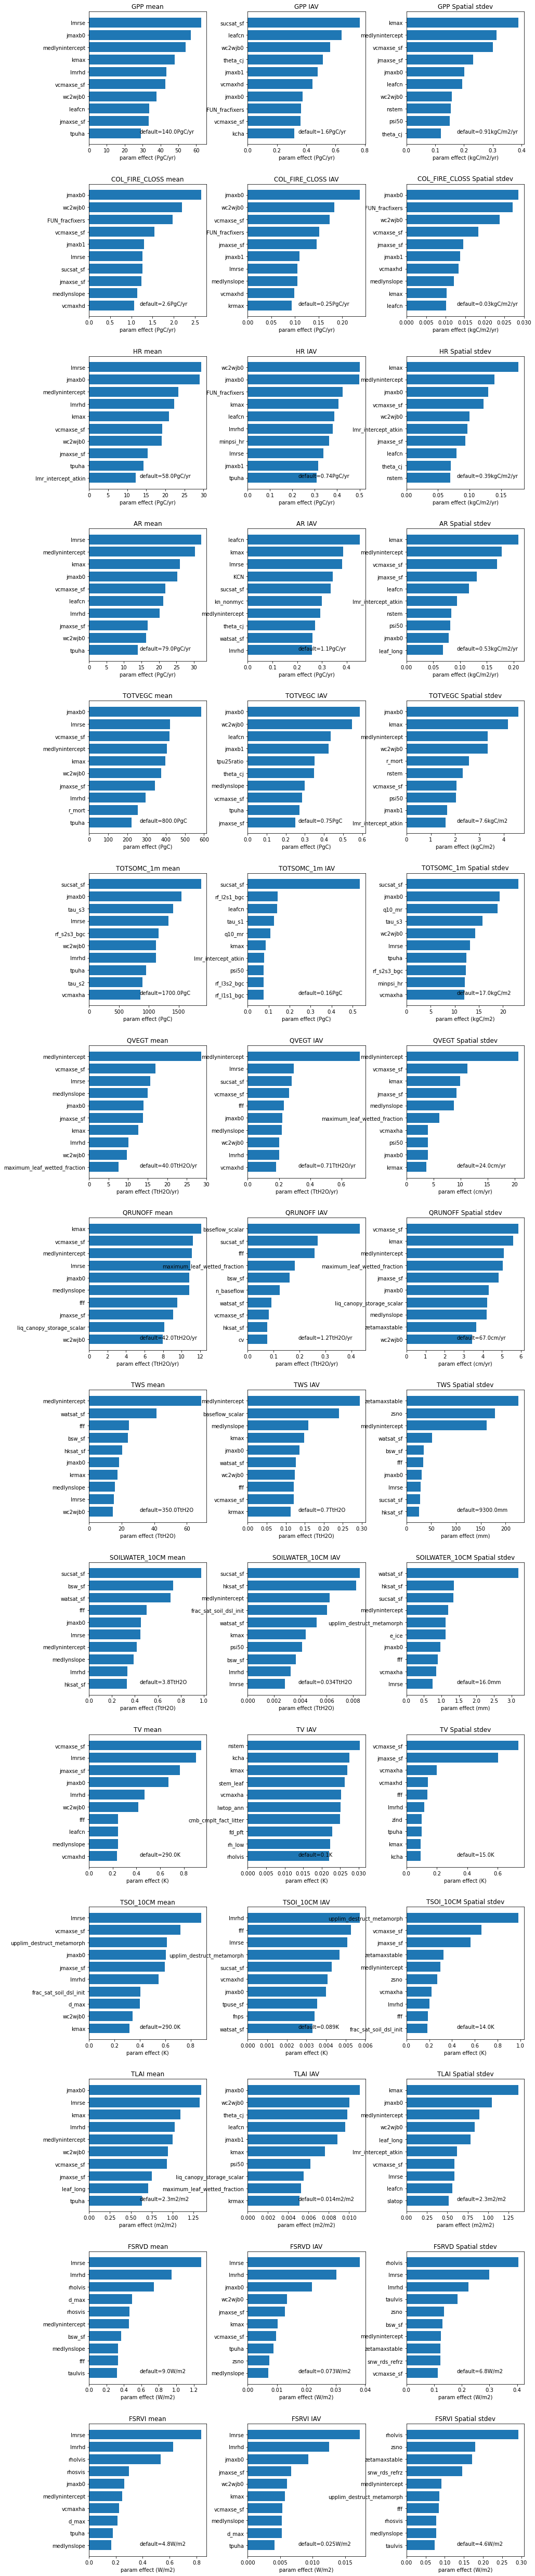

In [48]:
ds = get_ds([field for field in fields])
plt.figure(figsize=[15,6*len(fields)])
i=0
for field in fields:
    print(field)
    da=ds[field]
    for op,cf,unit in zip(ops,fields[field]['cfs'],fields[field]['units']):
        i+=1 
        effect,x=param_effect(da,ds.param,op,cf)
        a = np.sort(effect)
        b = np.argsort(effect)
        top10 = [uniques[i] for i in b[-10:]]

        plt.subplot(len(fields),3,i)
        plt.barh(range(10),a[-10:])
        plt.yticks(range(10),top10);
        plt.xlabel('param effect ('+unit+')')
        plt.title(field+' '+op);

        xmid = 0.45*max(a)
        xdef = '%s' % float('%.2g' % x[0].values)
        plt.text(xmid,0,'default='+xdef+unit)
    
plt.subplots_adjust(wspace=0.35)
plt.subplots_adjust(hspace=0.3)

In [51]:
ds = get_ds([field for field in fields])
i=0
ranks=[]
for field in fields:
    print(field)
    da=ds[field]
    for op,cf,unit in zip(ops,fields[field]['cfs'],fields[field]['units']):
        i+=1 
        effect,x=param_effect(da,ds.param,op,cf)
        a = np.sort(effect)
        b = np.argsort(effect)
        top10 = [uniques[i] for i in b[-10:]]
        rank = np.empty_like(a)
        rank[b] = np.arange(len(a))
        ranks.append(rank)



GPP
COL_FIRE_CLOSS
HR
AR
TOTVEGC
TOTSOMC_1m
QVEGT
QRUNOFF
TWS
SOILWATER_10CM
TV
TSOI_10CM
TLAI
FSRVD
FSRVI


In [57]:
nr = len(ranks)
avg_rank = np.zeros(len(ranks[0]))
for rank in ranks:
    avg_rank = avg_rank+1/nr*rank

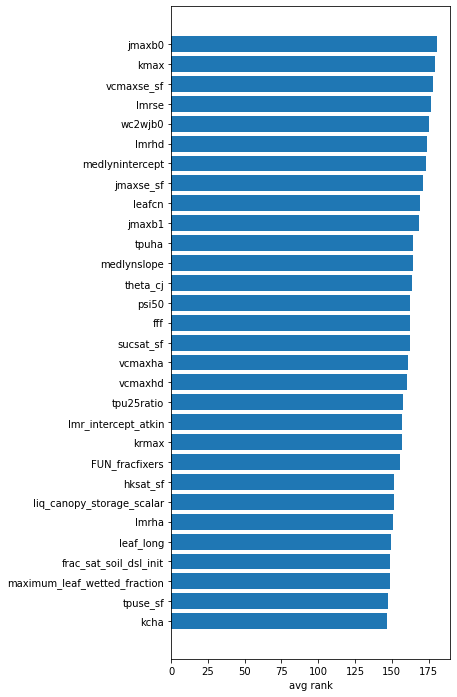

In [62]:
a = np.sort(avg_rank)
b = np.argsort(avg_rank)
plt.figure(figsize=[5,12])
top10 = [uniques[i] for i in b[-30:]]
plt.barh(range(30),a[-30:])
plt.yticks(range(30),top10)
plt.xlabel('avg rank');

In [69]:
i=-1
for p in uniques:
    i+=1
    if p=='KCN':
        print(avg_rank[i])

145.31111111111116


In [72]:
a[-40:]

array([140.64444444, 141.15555556, 142.4       , 142.51111111,
       143.4       , 143.86666667, 144.37777778, 145.11111111,
       145.31111111, 145.55555556, 146.55555556, 147.68888889,
       148.64444444, 148.82222222, 149.66666667, 150.71111111,
       151.4       , 151.75555556, 155.53333333, 156.71111111,
       157.04444444, 157.84444444, 160.15555556, 161.        ,
       161.97777778, 162.26666667, 162.57777778, 163.91111111,
       164.06666667, 164.44444444, 168.24444444, 168.91111111,
       171.13333333, 172.88888889, 173.88888889, 175.46666667,
       176.26666667, 178.04444444, 179.08888889, 180.51111111])

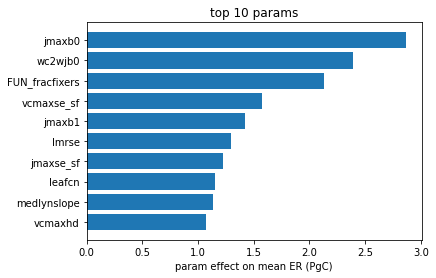

In [120]:
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-10:]]
plt.barh(range(10),a[-10:])
plt.yticks(range(10),top10);
plt.xlabel('param effect on mean ER (PgC)')
plt.title('top 10 params');

TWS


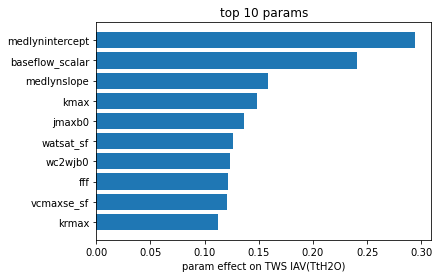

In [175]:
cf=1/365/1e9
field = 'TWS'
units = 'TtH2O'
op    = 'IAV'
effect,x=param_effect(field,op,cf)
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-10:]]
plt.barh(range(10),a[-10:])
plt.yticks(range(10),top10);
plt.xlabel('param effect on '+field+' '+op+'('+units+')')
plt.title('top 10 params');

SOILWATER_10CM


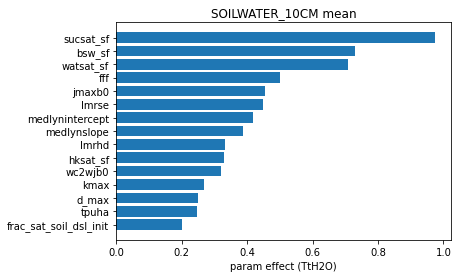

In [183]:
cf=1e-9/365
field = 'SOILWATER_10CM'
units = 'TtH2O'
op    = 'mean'
effect,x=param_effect(field,op,cf)
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-15:]]
plt.barh(range(15),a[-15:])
plt.yticks(range(15),top10);
plt.xlabel('param effect '+'('+units+')')
plt.title(field+' '+op);

QRUNOFF


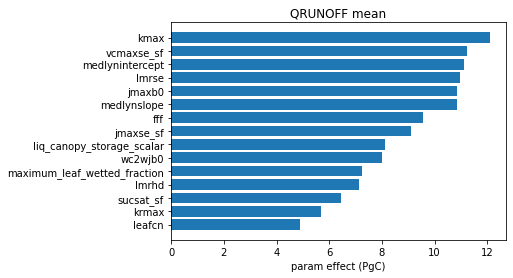

In [187]:
cf=24*60*60*1e-9
field = 'QRUNOFF'
units = 'PgC'
op    = 'mean'
effect,x=param_effect(field,op,cf)
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-15:]]
plt.barh(range(15),a[-15:])
plt.yticks(range(15),top10);
plt.xlabel('param effect '+'('+units+')')
plt.title(field+' '+op);

In [188]:
ix = x.param=='rootprof_beta'
x.isel(ens=ix)

<xarray.DataArray (ens: 2)>
array([42.57059685, 41.81982281])
Coordinates:
    param    (ens) <U32 'rootprof_beta' 'rootprof_beta'
Dimensions without coordinates: ens

In [133]:
cf=24*60*60*1e-9
qvegt,x=param_effect('QVEGT','mean',cf)

QVEGT


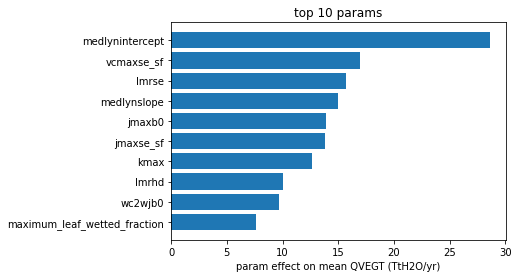

In [134]:
a = np.sort(qvegt)
b = np.argsort(qvegt)
top10 = [uniques[i] for i in b[-10:]]
plt.barh(range(10),a[-10:])
plt.yticks(range(10),top10);
plt.xlabel('param effect on mean QVEGT (TtH2O/yr)')
plt.title('top 10 params');

In [135]:
cf=24*60*60*1e-9
effect,x=param_effect('COL_FIRE_CLOSS','mean',cf)

COL_FIRE_CLOSS


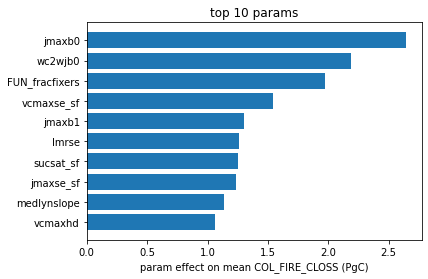

In [136]:
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-10:]]
plt.barh(range(10),a[-10:])
plt.yticks(range(10),top10);
plt.xlabel('param effect on mean COL_FIRE_CLOSS (PgC)')
plt.title('top 10 params');

In [137]:
pp = xr.open_dataset(files[0])

In [139]:
cf=24*60*60*1e-9
effect,x=param_effect('QRUNOFF','mean',cf)

QRUNOFF


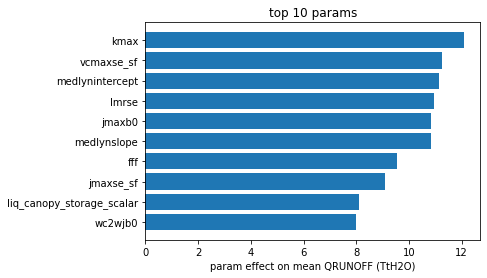

In [140]:
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-10:]]
plt.barh(range(10),a[-10:])
plt.yticks(range(10),top10);
plt.xlabel('param effect on mean QRUNOFF (TtH2O)')
plt.title('top 10 params');

TLAI


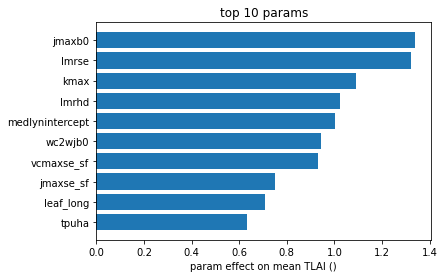

In [142]:
cf=1/365/la.sum()
field = 'TLAI'
units = ''
effect,x=param_effect(field,'mean',cf)
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-10:]]
plt.barh(range(10),a[-10:])
plt.yticks(range(10),top10);
plt.xlabel('param effect on mean '+field+' ('+units+')')
plt.title('top 10 params');

TG


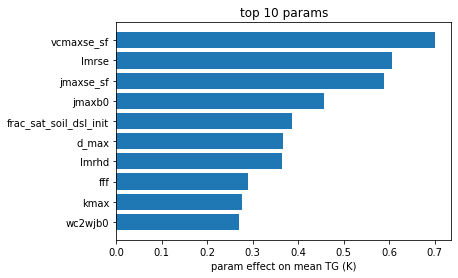

In [144]:
cf=1/365/la.sum()
field = 'TG'
units = 'K'
effect,x=param_effect(field,'mean',cf)
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-10:]]
plt.barh(range(10),a[-10:])
plt.yticks(range(10),top10);
plt.xlabel('param effect on mean '+field+' ('+units+')')
plt.title('top 10 params');

TWS


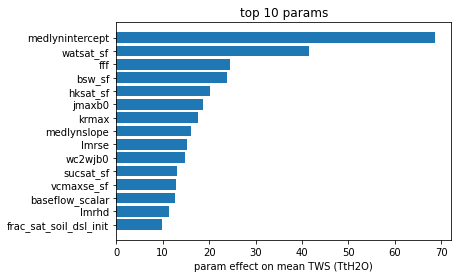

In [148]:
cf=1e-9/365
field = 'TWS'
units = 'TtH2O'
effect,x=param_effect(field,'mean',cf)
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-15:]]
plt.barh(range(15),a[-15:])
plt.yticks(range(15),top10);
plt.xlabel('param effect on mean '+field+' ('+units+')')
plt.title('top 10 params');

SOILWATER_10CM


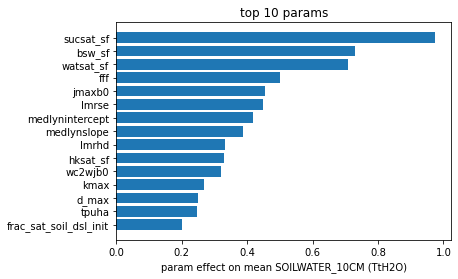

In [147]:
cf=1e-9/365
field = 'SOILWATER_10CM'
units = 'TtH2O'
effect,x=param_effect(field,'mean',cf)
a = np.sort(effect)
b = np.argsort(effect)
top10 = [uniques[i] for i in b[-15:]]
plt.barh(range(15),a[-15:])
plt.yticks(range(15),top10);
plt.xlabel('param effect on mean '+field+' ('+units+')')
plt.title('top 10 params');

In [11]:
# defining a preprocessing function
#   this way I only take GPP and TWS
#   otherwise you'll read in ~500 data_vars (for h0)
data_vars=['GPP','TWS']
def preprocess(ds):
    return ds[data_vars]

In [12]:
%%time
ds=xr.open_mfdataset(files,
                     combine='nested',
                     concat_dim='ens',
                     parallel=True,
                     preprocess=preprocess)
ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

CPU times: user 1.65 s, sys: 113 ms, total: 1.77 s
Wall time: 12.3 s


In [16]:
ds.GPP

<xarray.DataArray 'GPP' (ens: 371, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(371, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [13]:


ds['param']    = xr.DataArray(params,dims='ens')
ds['minmax']   = xr.DataArray(minmax,dims='ens')
ds['member']   = xr.DataArray(members,dims='ens')

In [29]:
%%time
nyrs=10
gpp_ann      = 24*60*60*(month_wts(nyrs)*ds.GPP).sum(dim='time')/nyrs
gpp_ann_glob = 1e-9*(la*gpp_ann).sum(dim='gridcell').compute()


CPU times: user 2.13 s, sys: 63.9 ms, total: 2.19 s
Wall time: 5.34 s


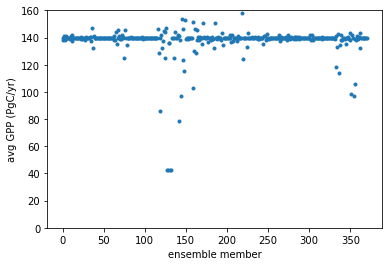

In [33]:
plt.plot(gpp_ann_glob,'.')
plt.xlabel('ensemble member')
plt.ylabel('avg GPP (PgC/yr)')
plt.ylim([0,160]);

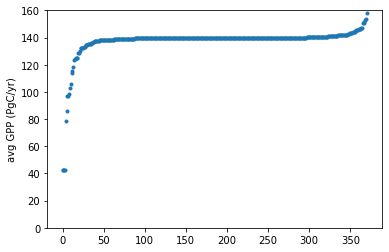

In [34]:
plt.plot(sorted(gpp_ann_glob),'.')
plt.ylabel('avg GPP (PgC/yr)')
plt.ylim([0,160]);

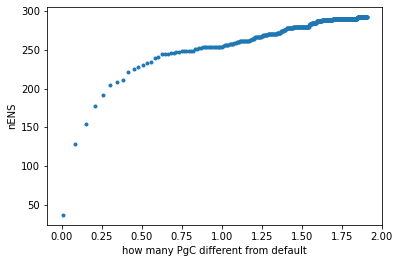

In [55]:
gpp0 = gpp_ann_glob[0]
x = np.zeros(400)
gs = np.log10(1.01+np.arange(400)/5)
for i,g in zip(range(400),gs):
    ix = abs(gpp_ann_glob-gpp0)<g
    x[i] = ix.sum()

    
plt.plot(gs,x,'.')
plt.xlabel('how many PgC different from default')
plt.ylabel('nENS');

In [22]:
%%time
nyrs=10
tws_ann      = (month_wts(nyrs)*ds.TWS).sum(dim='time')/(365*nyrs)
tws_ann_glob = 1e-9*(la*tws_ann).sum(dim='gridcell').compute()

CPU times: user 2.71 s, sys: 118 ms, total: 2.83 s
Wall time: 11.2 s


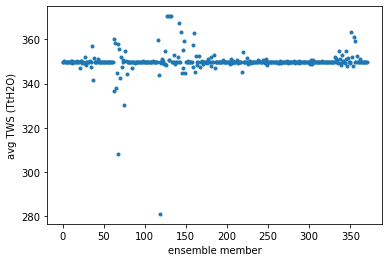

In [24]:
plt.plot(tws_ann_glob,'.')
plt.xlabel('ensemble member')
plt.ylabel('avg TWS (TtH2O)');

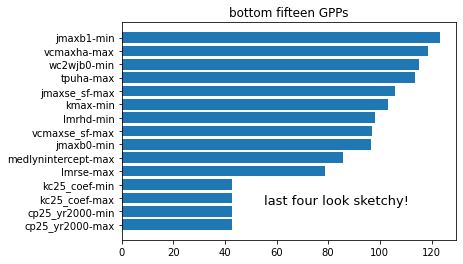

In [25]:
gpp_sort = np.sort(gpp_ann_glob)[:15]
ix       = np.argsort(gpp_ann_glob)[:15]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(15),gpp_sort)
plt.yticks(np.arange(15),ticks)
plt.title('bottom fifteen GPPs')
plt.text(55,1.5,'last four look sketchy!',fontsize=13);

In [48]:
#inspect those paramfiles
pdir = '/glade/scratch/djk2120/PPEn08/paramfiles/'

param  = 'kc25_coef'

for minmax in ['min','max']:
    ix1 = ds.param==param
    ix2 = ds.minmax==minmax
    ix  = np.logical_and(ix1,ix2)

    member = ds.member[ix].values[0]
    pfile  = pdir+member+'.nc'

    p = xr.open_dataset(pfile)[param]
    print(p)

#inspect default
p=xr.open_dataset(pdir+'OAAT0000.nc')[param]
print(p)

    

<xarray.DataArray 'kc25_coef' ()>
array(266.)
Attributes:
    long_name:  Michaelis-Menten constant at 25degC for CO2
    units:      mol/mol
<xarray.DataArray 'kc25_coef' ()>
array(454.)
Attributes:
    long_name:  Michaelis-Menten constant at 25degC for CO2
    units:      mol/mol
<xarray.DataArray 'kc25_coef' ()>
array(0.000405)
Attributes:
    long_name:  Michaelis-Menten constant at 25degC for CO2
    units:      mol/mol


In [49]:
#inspect those paramfiles
pdir = '/glade/scratch/djk2120/PPEn08/paramfiles/'

param  = 'cp25_yr2000'

for minmax in ['min','max']:
    ix1 = ds.param==param
    ix2 = ds.minmax==minmax
    ix  = np.logical_and(ix1,ix2)

    member = ds.member[ix].values[0]
    pfile  = pdir+member+'.nc'

    p = xr.open_dataset(pfile)[param]
    print(p)

#inspect default
p=xr.open_dataset(pdir+'OAAT0000.nc')[param]
print(p)


<xarray.DataArray 'cp25_yr2000' ()>
array(35.)
Attributes:
    long_name:  CO2 compensation point at 25degC at present day O2
    units:      mol/mol
<xarray.DataArray 'cp25_yr2000' ()>
array(44.7)
Attributes:
    long_name:  CO2 compensation point at 25degC at present day O2
    units:      mol/mol
<xarray.DataArray 'cp25_yr2000' ()>
array(4.275e-05)
Attributes:
    long_name:  CO2 compensation point at 25degC at present day O2
    units:      mol/mol


In [50]:
#inspect those paramfiles
pdir = '/glade/scratch/djk2120/PPEn08/paramfiles/'

param  = 'ko25_coef'

for minmax in ['min','max']:
    ix1 = ds.param==param
    ix2 = ds.minmax==minmax
    ix  = np.logical_and(ix1,ix2)

    member = ds.member[ix].values[0]
    pfile  = pdir+member+'.nc'

    p = xr.open_dataset(pfile)[param]
    print(p)

#inspect default
p=xr.open_dataset(pdir+'OAAT0000.nc')[param]
print(p)


<xarray.DataArray 'ko25_coef' ()>
array(207.)
Attributes:
    long_name:  Michaelis-Menten constant at 25degC for O2
    units:      mol/mol
<xarray.DataArray 'ko25_coef' ()>
array(395.)
Attributes:
    long_name:  Michaelis-Menten constant at 25degC for O2
    units:      mol/mol
<xarray.DataArray 'ko25_coef' ()>
array(0.2784)
Attributes:
    long_name:  Michaelis-Menten constant at 25degC for O2
    units:      mol/mol


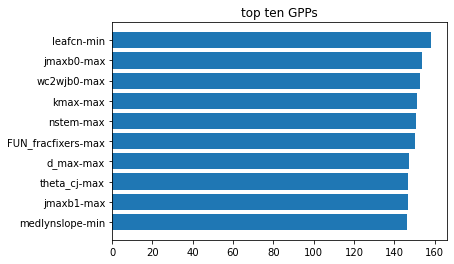

In [26]:
gpp_sort = np.sort(gpp_ann_glob)[-10:]
ix       = np.argsort(gpp_ann_glob)[-10:]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(10),gpp_sort)
plt.yticks(np.arange(10),ticks)
plt.title('top ten GPPs');

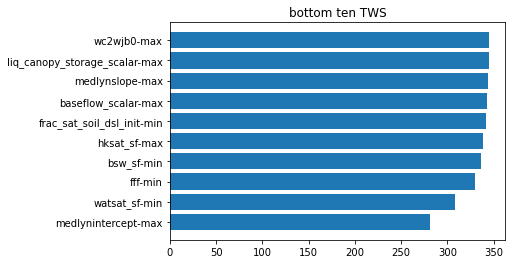

In [205]:
tws_sort = np.sort(tws_ann_glob)[:10]
ix       = np.argsort(tws_ann_glob)[:10]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(10),tws_sort)
plt.yticks(np.arange(10),ticks)
plt.title('bottom ten TWS');

top4 look sketchy (again)


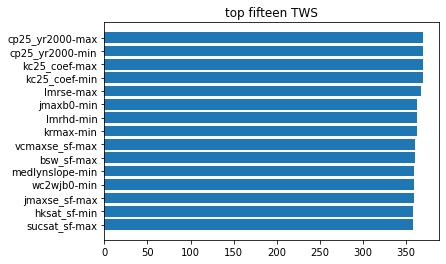

In [209]:
tws_sort = np.sort(tws_ann_glob)[-15:]
ix       = np.argsort(tws_ann_glob)[-15:]
params   = ds.param[ix].values
minmax   = ds.minmax[ix].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]
plt.barh(np.arange(15),tws_sort)
plt.yticks(np.arange(15),ticks)
plt.title('top fifteen TWS');
print('top4 look sketchy (again)')

### are any members BFB?

In [65]:
gpp0 = ds.GPP.sel(ens=0)
nmem = len(members)
for i in range(nmem):
    eqls = ds.GPP.isel(ens=i)==gpp0
    bfb1 = eqls.all()
    if bfb1:
        print(ds.param.isel(ens=i).values)

default
perched_baseflow_scalar
perched_baseflow_scalar
xdrdt
xdrdt
fnr
act25
act25
frootcn_max
frootcn_max
frootcn_min
frootcn_min
leafcn_max
leafcn_max
leafcn_min
leafcn_min
fm_dstem
fm_dstem


### spinup

In [114]:
%%time
data_vars=['TOTECOSYSC','TOTSOMC','TOTSOMC_1m']
def preprocess(ds):
    return ds[data_vars]
ds=xr.open_mfdataset(files,
                     combine='nested',
                     concat_dim='ens',
                     parallel=True,
                     preprocess=preprocess)
ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
#append some useful information about the parameters
csvfile='/glade/scratch/djk2120/PPEn08/OAAT_apr2020.csv'
keys=pd.read_csv(csvfile,header=None)
params=[]
minmax=[]
for member in members:
    ix = member==keys[0]
    params.append(keys[1][ix].values[0])
    minmax.append(keys[2][ix].values[0])
ds['param']    = xr.DataArray(params,dims='ens')
ds['minmax']   = xr.DataArray(minmax,dims='ens')
ds['member']   = xr.DataArray(members,dims='ens')

CPU times: user 2.44 s, sys: 378 ms, total: 2.82 s
Wall time: 14.1 s


In [117]:
#calculate average TEC
ny  = 10
cf  = 1/365/ny

tec0   = ds.TOTECOSYSC+ds.TOTSOMC_1m-ds.TOTSOMC
tec_1m = cf*(month_wts(10)*tec0).sum(dim='time').compute()

In [124]:
##go get the postSASU run
sasu_files = []
hdir='/glade/scratch/djk2120/PPEn08/CTL2010/hist_postSASU/'
for member in members:
    file = glob.glob(hdir+'PPEn08_CTL2010_postSASU_'+member+'*.h0.*')
    if len(file)==0:
        print('ERROR: '+member+' not found')
    else:
        sasu_files.append(file[0])
        
data_vars=['TOTECOSYSC','TOTSOMC','TOTSOMC_1m']
def preprocess(ds):
    return ds[data_vars]
ds=xr.open_mfdataset(sasu_files,
                     combine='nested',
                     concat_dim='ens',
                     parallel=True,
                     preprocess=preprocess)

#append some useful information about the parameters
csvfile='/glade/scratch/djk2120/PPEn08/OAAT_apr2020.csv'
keys=pd.read_csv(csvfile,header=None)
params=[]
minmax=[]
for member in members:
    ix = member==keys[0]
    params.append(keys[1][ix].values[0])
    minmax.append(keys[2][ix].values[0])
ds['param']    = xr.DataArray(params,dims='ens')
ds['minmax']   = xr.DataArray(minmax,dims='ens')
ds['member']   = xr.DataArray(members,dims='ens')

In [126]:
ixt = np.arange(41)>30
cf  = 1
tec0        = ds.TOTECOSYSC+ds.TOTSOMC_1m-ds.TOTSOMC
tec_1m_ps   = cf*tec0.isel(time=ixt).mean(dim='time').compute()

In [127]:
dtec = abs(tec_1m-tec_1m_ps)/10    #gC/m2/yr



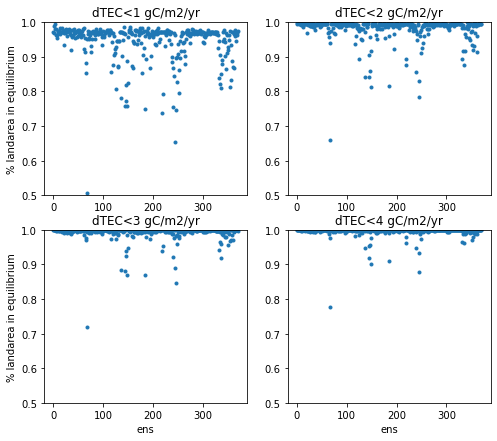

In [133]:
plt.figure(figsize=[8,7])
for threshold in [1,2,3,4]:
    plt.subplot(2,2,threshold)
    eqbl = dtec<threshold
    eqbl_area = (la*eqbl).sum(dim='gridcell')/la.sum()
    eqbl_area.plot.line('.')
    plt.title('dTEC<'+str(threshold)+' gC/m2/yr')
    if (threshold==1)|(threshold==3):
        plt.ylabel('% landarea in equilibrium')
    if threshold<3:
        plt.xlabel('')
    plt.ylim([0.5,1])

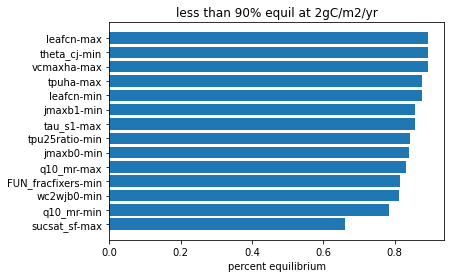

In [144]:
threshold=2
eqbl = dtec<threshold
eqbl_area = (la*eqbl).sum(dim='gridcell')/la.sum()
ix = eqbl_area<0.9
nx = ix.sum().values

asort = np.sort(eqbl_area[ix])
ixs   = np.argsort(eqbl_area[ix])

params = ds.param[ix][ixs].values
minmax = ds.minmax[ix][ixs].values
ticks = [p+'-'+m for p,m in zip(params,minmax)]

plt.barh(range(nx),asort)
plt.yticks(range(nx),ticks)
plt.xlabel('percent equilibrium')
plt.title('less than 90% equil at 2gC/m2/yr');

### survivability

In [7]:
## go get the PFT output
pft_files = []
hdir='/glade/scratch/djk2120/PPEn08/CTL2010/hist/'
for member in members:
    file = glob.glob(hdir+'PPEn08_CTL2010_'+member+'*.h1.*')
    if len(file)==0:
        print('ERROR: '+member+' not found')
    else:
        pft_files.append(file[0])
        
data_vars=['TLAI']
def preprocess(ds):
    return ds[data_vars]
ds=xr.open_mfdataset(pft_files,
                     combine='nested',
                     concat_dim='ens',
                     parallel=True,
                     preprocess=preprocess)
tmp = xr.open_dataset(pft_files[0])
ds['pft']=tmp['pfts1d_itype_veg'] #reassign pft variable for easier analysis

In [15]:
#append some useful information about the parameters
csvfile='/glade/scratch/djk2120/PPEn08/OAAT_apr2020.csv'
keys=pd.read_csv(csvfile,header=None)
params=[]
minmax=[]
for member in members:
    ix = member==keys[0]
    params.append(keys[1][ix].values[0])
    minmax.append(keys[2][ix].values[0])
ds['param']    = xr.DataArray(params,dims='ens')
ds['minmax']   = xr.DataArray(minmax,dims='ens')
ds['member']   = xr.DataArray(members,dims='ens')

In [8]:
npixels = (ds['TLAI'].max(dim='time')>0.1).groupby('pft').sum().compute()
surv    = 100*npixels/npixels.isel(ens=0).compute().isel(pft=1+np.arange(15))

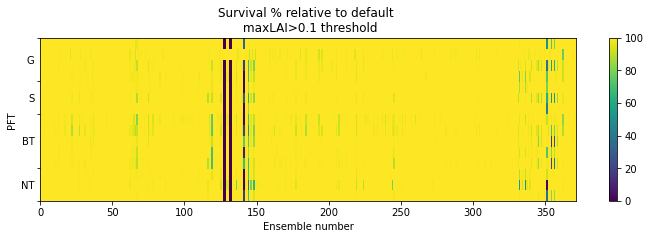

In [9]:
fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(surv.T,vmin=0,vmax=100)
plt.colorbar()
plt.title('Survival % relative to default \n maxLAI>0.1 threshold')
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

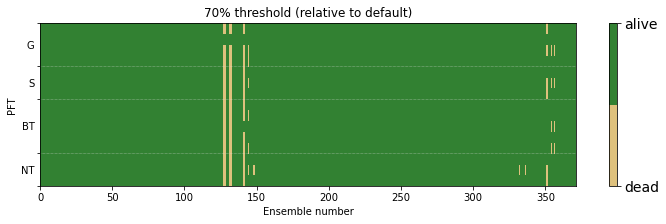

In [56]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([50,130,50])/256
newcmp = matplotlib.colors.ListedColormap(vals)

thresh = 70
alive = surv.T>thresh
fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(alive,cmap=newcmp)

cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=14) 
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
for y in [3,8,11]:
    plt.plot([0,len(ds.ens)],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.title(str(thresh)+'% threshold (relative to default)')
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

In [58]:
ix = alive.sum(dim='pft')<15

In [59]:
[p+'-'+m for p,m in zip(ds.param[ix].values,ds.minmax[ix].values)]

['kc25_coef-min',
 'kc25_coef-max',
 'cp25_yr2000-min',
 'cp25_yr2000-max',
 'lmrse-max',
 'jmaxb0-min',
 'wc2wjb0-min',
 'vcmaxha-max',
 'tpuha-max',
 'lmrhd-min',
 'vcmaxse_sf-max',
 'jmaxse_sf-max']